In [1]:
from Scripts.ProcessingEmbeddings import *
from Scripts.HardDebias import *
from Scripts.utils import *

In [2]:
import codecs
import json
import numpy as np
import sklearn

In [3]:
#Create an embeddings object with the embeddings file
glove=Embeddings('Data/glove-wiki-gigaword-300.txt', gensim=False)

Loading Data/glove-wiki-gigaword-300.txt embeddings
vectors shape: (400000, 300), word2idx length: 400000, vocab length: 400000


In [4]:
# From the embeddings object, get the vectors, the word2idx dictionary, the vocab list, and the dict_vectors dictionary
# Because the gensim embeddings carry no information on the file, we need to use the built-in function from gensim to get the vocab in descending frequency.
glove.model.sort_by_descending_frequency()
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()

#print the first 20 words in the vocab
print(vocab[:20])

#Print the shape of the vectors
print("vectors shape", vectors.shape)

#Print a boolean to check if there are any NaNs in the vectors
print("Missing values in vectors?", np.isnan(vectors).any())

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']
vectors shape (400000, 300)
Missing values in vectors? False


In [5]:
# Getting a limited vocabulary to debias the embeddings.
vocab_nopunct, vectors_nopunct, word2idx_nopunct, dict_vec_nopunct = glove.limit_vocab(vectors, word2idx, vocab)

100%|██████████| 400000/400000 [00:00<00:00, 641317.65it/s]


Size of limited vocabulary: 327185


## Hard-Debias Algorithm

#### Preliminaries

In [6]:
# Cleaning the vocabulary from pounctuation and numbers
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(
    vectors, word2idx, vocab)


100%|██████████| 400000/400000 [00:00<00:00, 626394.87it/s]


Size of limited vocabulary: 327185


In [172]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets = {
    "gender": [
        ['she', 'he'], ['herself', 'himself'], 
        ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
        ['mother', 'father'], ['woman', 'man'], ['mary', 'john'],
        ['gal', 'guy'], ['female', 'male'], ['aunt', 'uncle']],

    "race": [
        ["black", "caucasian", "asian", "hispanic"],
      		["african", "caucasian", "asian", "hispanic"],
      		["black", "white", "asian", "latino"],
      		["africa", "europe", "asia", "mexico"],
      		["africa", "america", "china", "latin-america"],
    ]
}

#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], 
        ["Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], 
        ["grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], 
        ["wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], 
        ["brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman","congresswoman"], 
        ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"],
        ["fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], 
        ["gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], 
        ["his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"],
        ["men", "women"], ["nephew", "niece"], ["prince", "princess"],
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], 
        ["twin_brother", "twin_sister"]]}

#Words taken from Wang et al. to enrich the equalizing pairs
female_vocab = ['countrywoman',  'witches',  'maidservant',  'mothers',  'diva',  'actress',  'spinster',  'mama',  'duchesses',  'countrywomen',  'hostesses',  'suitors',  'menopause',  'clitoris',  'princess',  'governesses',  'abbess',  'women',  'widow',  'ladies',  'sorceresses',  'madam',  'brides',  'baroness',  'niece',  'widows',  'lady',  'sister',  'brides',  'nun',  'obstetrics',  'her',  'marchioness',  'princesses',  'empresses',  'mare',  'chairwoman',  'convent',  'priestesses',  'girlhood',  'ladies',  'queen',  'gals',  'mommies',  'maid',  'spokeswoman',  'seamstress',  'cowgirls',  'chick',  'spinsters',  'empress',  'mommy',  'gals',  'enchantress',  'gal',  'motherhood',  'estrogen',  'godmother',  'strongwoman',  'goddess',  'matriarch',  'aunt',  'chairwomen',  'maam',
                'sisterhood',  'hostess',  'estradiol',  'wife',  'mom',  'stewardess',  'females',  'spokeswomen',  'ma',  'belle',  'minx',  'maiden',  'witch',  'miss',  'nieces',  'mothered',  'cow',  'belles',  'granddaughter',  'fiancees',  'stepmothers',  'grandmothers',  'schoolgirl',  'hen',  'granddaughters',  'bachelorette',  'camerawoman',  'moms',  'her',  'mistress',  'lass',  'policewoman',  'nun',  'actresses',  'saleswomen',  'girlfriend',  'councilwoman',  'lady',  'stateswoman',  'maternal',  'lass',  'landlady',  'ladies',  'wenches',  'sorority',  'duchess',  'ballerina',  'chicks',  'fiancee',  'fillies',  'wives',  'she',  'businesswoman',  'masseuses',  'heroine',  'doe',  'girlfriends',  'queens',  'sisters',  'stepmother',  'daughter',  'cowgirl',  'daughters',  'soprano',
                'saleswoman',  'mistress',  'nuns',  'headmistresses',  'lasses',  'congresswoman',  'housewife',  'priestess',  'abbesses',  'toque',  'sororities',  'stewardesses',  'filly',  'czarina',  'stepdaughters',  'herself',  'girls',  'lionesses',  'lady',  'vagina',  'hers',  'masseuse',  'cows',  'aunts',  'wench',  'toques',  'wife',  'lioness',  'sorceress',  'mother',  'lesbians',  'female',  'waitresses',  'ovum',  'ovary',  'stepdaughter',  'businesswomen',  'heiress',  'waitress',  'headmistress',  'woman',  'governess',  'bride',  'grandma',  'bride',  'gal',  'lesbian',  'ladies',  'girl',  'grandmother',  'mare',  'hens',  'nuns',  'maidservants',  'heroines']
male_vocab = ['countryman',  'wizards',  'manservant',  'fathers',  'divo',  'actor',  'bachelor',  'papa',  'dukes',  'countrymen',  'hosts',  'airmen',  'andropause',  'penis',  'prince',  'governors',  'abbot',  'men',  'widower',  'gentlemen',  'sorcerers',  'sir',  'bridegrooms',  'baron',  'nephew',  'widowers',  'lord',  'brother',  'grooms',  'priest',  'andrology',  'his',  'marquis',  'princes',  'emperors',  'stallion',  'chairman',  'monastery',  'priests',  'boyhood',  'fellas',  'king',  'dudes',  'daddies',  'manservant',  'spokesman',  'tailor',  'cowboys',  'dude',  'bachelors',  'emperor',  'daddy',  'guys',  'enchanter',  'guy',  'fatherhood', 
                'androgen',  'godfather',  'strongman',  'god',  'patriarch',  'uncle',  'chairmen',  'sir',  'brotherhood',  'host',  'testosterone',  'husband',  'dad',  'steward',  'males',  'spokesmen',  'pa',  'beau',  'stud',  'bachelor',  'wizard',  'sir',  'nephews',  'fathered',  'bull',  'beaus',  'grandson',  'fiances',  'stepfathers',  'grandfathers',  'schoolboy',  'rooster',  'grandsons',  'bachelor',  'cameraman',  'dads',  'him',  'master',  'lad',  'policeman',  'monk',  'actors',  'salesmen',  'boyfriend',  'councilman',  'fella',  'statesman',  'paternal',  'chap',  'landlord',  'lords',  'blokes',  'fraternity',  'duke',  'dancer',  'dudes',  'fiance',
                'colts',  'husbands',  'he',  'businessman',  'masseurs',  'hero',  'deer',  'boyfriends',  'kings',  'brothers',  'stepfather',  'son',  'cowboy',  'sons',  'baritone',  'salesman',  'paramour',  'monks',  'headmasters',  'lads',  'congressman',  'househusband',  'priest',  'abbots',  'beard',  'fraternities',  'stewards',  'colt',  'czar',  'stepsons',  'himself',  'boys',  'lions',  'gentleman',  'penis',  'his',  'masseur',  'bulls',  'uncles',  'bloke',  'beards',  'hubby',  'lion',  'sorcerer',  'father',  'gays',  'male',  'waiters',  'sperm',  'prostate',  'stepson',  'businessmen',  'heir',  'waiter',  'headmaster',  'man',  'governor',  'bridegroom', 
                'grandpa',  'groom',  'dude',  'gay',  'gents',  'boy',  'grandfather',  'gelding',  'roosters',  'priests',  'busboy',  'heros']

#added the gendered pairs to the equalizing list (equalizing_lists['gender'] if the pairs are not there already
gendered_pairs = list(zip(male_vocab, female_vocab))
list_pairs = [tuple for tuple in gendered_pairs if tuple not in equalizing_lists['gender']]
equalizing_lists['gender'] = equalizing_lists['gender']+list_pairs

#Some of the words were taken from the analogies' templates from Cheng and Manzini.
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories.
neutral_words = ["manager", "executive", "doctor", "lawyer", "programmer",
                 "scientist", "soldier", "supervisor", "rancher", "janitor",
                 "firefighter", "officer", "secretary", "nurse", "clerk", "artist",
                 "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist",
                 "receptionist", "counselor", "leader", "farmer",
                 "engineer", "laborer", "teacher",
                 "slave", "musician", "runner", "criminal", "homeless",
                 "greedy", "cheap", "hairy", "liberal",
                 "judgemental", "conservative", "familial",
                 "violent", "terrorist", "dirty", "uneducated", "educated"]


#However, also the vocabulary without the gendered words from the list can be conceived as neutral, according to Bolukbasi et al.


#### Gender Debiasing

In [8]:
#putting the def_sets on the right format for debiasing
def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])


In [9]:
deb_vect_gender, deb_vocab_gender, deb_word2idx_gender,deb_dict_gender = hard_debias(vectors,
                             dict_vectors, 
                             word2idx_cleaned,
                             vocab_cleaned, 
                             equalizing_lists['gender'], 
                             def_set_gender,
                             1,
                             normalize_dir=False,
                             normalize=None,
                             centralizing=True)

Length of vectors set: 22
Running PCA with 1 components


## Evaluation

In [12]:
from Scripts.Visualization import *
from Scripts.Evaluation import *
import pandas as pd

### Gender Bias Pre-Post

In [94]:
# To compute the gender bias, we need to get the embeddings of "he" and "she"
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']

# Using the gender bias function to compute the bias of all the words in the limited dataset
#We create a dictionary with the word as key and the bias as value
simple_gender_bias_original = compute_gender_simple_bias(dict_vec_cleaned, he_embed, she_embed)

In [14]:
gender_direction = identify_bias_subspace(
    dict_vectors, def_set_gender, 1, centralizing=True)


Length of vectors set: 22
Running PCA with 1 components


In [15]:
gender_bias_original2 = compute_direct_bias(
    dict_vectors, vocab_cleaned, gender_direction)


In [16]:
compute_average_bias(deb_dict_gender, neutral_words, gender_direction)


0.026869855613921773

In [107]:
gender_bias_original2 = compute_direct_bias(
    deb_dict_gender, neutral_words, gender_direction)


In [18]:
gender_bias_after_debiasing=compute_gender_simple_bias(deb_dict_gender, he_embed, she_embed)

In [47]:
occupations = ['assistant','secretary','data scientist', 'scientist', 'politician','janitor', 'hairdresser','teacher', 'bartender','midwife','doctor','ballerina','dancer','pediatrician','surgeon', 'physician', 'shopkeeper',  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists', 'guitarists','carpenter','clerk','manager','supervisor','driver','software developer','lawyer','pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro','lecturer','salesperson','homemaker', 'receptionist','librarian', 'nanny', 'bookkeeper', 'stylist','housekeeper','guidance counselor','skipper', 'protege','philosopher','captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher','pilot', 'boss']


In [18]:
bias_df=get_bias_score_df_from_list(simple_gender_bias_original,gender_bias_after_debiasing, occupations,vocab_cleaned,deb_vocab_gender)
plot_bias_bar(bias_df, "Gender bias on occupations (original vs debiased)", "Occupations")

In [19]:
c_w2i, c_vocab, female_words, male_words, y_true=getting_biased_words(simple_gender_bias_original, def_sets['gender'], 500, word2idx)


precision 1.0


(1.0, <AxesSubplot:title={'center':'GloVe_original'}>)

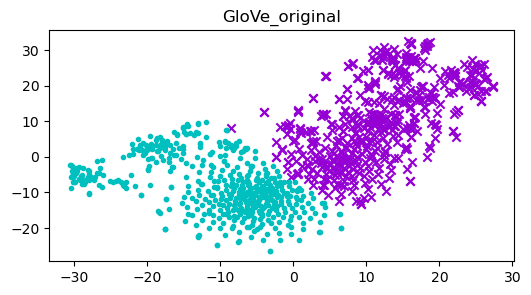

In [20]:
gendered_vectors=utils.extract_vectors(male_words + female_words, vectors_cleaned, word2idx_cleaned)
cluster_and_visualize(male_words + female_words,
                      np.array(gendered_vectors), 'GloVe_original', y_true, random_state=42)


precision 0.686


(0.686, <AxesSubplot:title={'center':'Debiased_GloVe'}>)

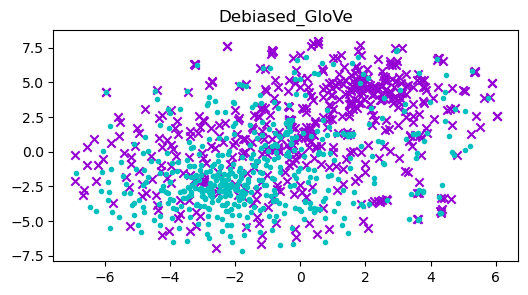

In [21]:
gendered_debiased_vectors = utils.extract_vectors(
    male_words + female_words, deb_vect_gender, deb_word2idx_gender)

cluster_and_visualize(male_words + female_words, np.array(gendered_debiased_vectors),
                      'Debiased_GloVe', y_true, random_state=42)


###  Random Words: bias scores and neighbors

In [28]:
from collections import defaultdict
#set a seed for reproducibility
np.random.seed(42)
#choosing random words from the vocabulary
random_words = np.random.choice(vocab_cleaned[:10000], size=50)

#setting parameters for the gensim method "most_similar"
topn = 3


In [29]:
random_words

array(['clouds', 'italy', 'anymore', 'cardinals', 'honest', 'eventual',
       'community', 'staying', 'sadr', 'vertical', 'henry', 'love',
       'rubin', 'drawn', 'monument', 'breast', 'jeffrey', 'pass',
       'rushed', 'maryland', 'withdrawn', 'parole', 'listened', 'rugby',
       'garbage', 'fears', 'neighboring', 'personalities', 'deceased',
       'political', 'concluded', 'operate', 'reflected', 'controlled',
       'symbols', 'session', 'female', 'revolutionary', 'consensus',
       'roc', 'albania', 'carpet', 'evaluate', 'destinations', 'colombia',
       'physicians', 'lobbyists', 'travels', 'laura', 'loyalty'],
      dtype='<U18')

In [30]:
#Getting the gender bias score for the random words list
bias_df = get_bias_score_df_from_list(
    simple_gender_bias_original, gender_bias_after_debiasing, random_words, vocab_cleaned, deb_vocab_gender)
plot_bias_bar(
    bias_df, "Gender bias on random_words (original vs debiased)", "Random_words")


In [31]:
k_neigh= get_k_nearest_neighbors(random_words, dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=50)

100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


In [32]:
list_neigh = get_list_neighbors(k_neigh)

In [33]:
from Scripts.Evaluation import get_frequency_original_neighbors
neig_freq2=get_frequency_original_neighbors(
    random_words, k_neigh, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=50)

df_freq = pd.DataFrame(neig_freq2, columns=['word', 'previous_neighbours', 'freq'])


50it [01:19,  1.59s/it]


In [34]:
import plotly_express as px
#plot the frequency of the original neighbours in the debiased network in a horizontal bar chart

fig = px.bar(df_freq, x='word', y='freq', title='Proportion of original 50 neighbours in the debiased k-vicinity of each word',
             labels={'freq':'Proportion', 'word':'Word'},
             height=500, width=1000)
#update the layout of the plot: update the y axis to be between 0 and 0.5 and the x axis to include all ticks
fig.update_layout(yaxis=dict(range=[0, 0.5]))

fig.show()

In [35]:
k_neigh_debiased= get_k_nearest_neighbors(random_words, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, k=50)

100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


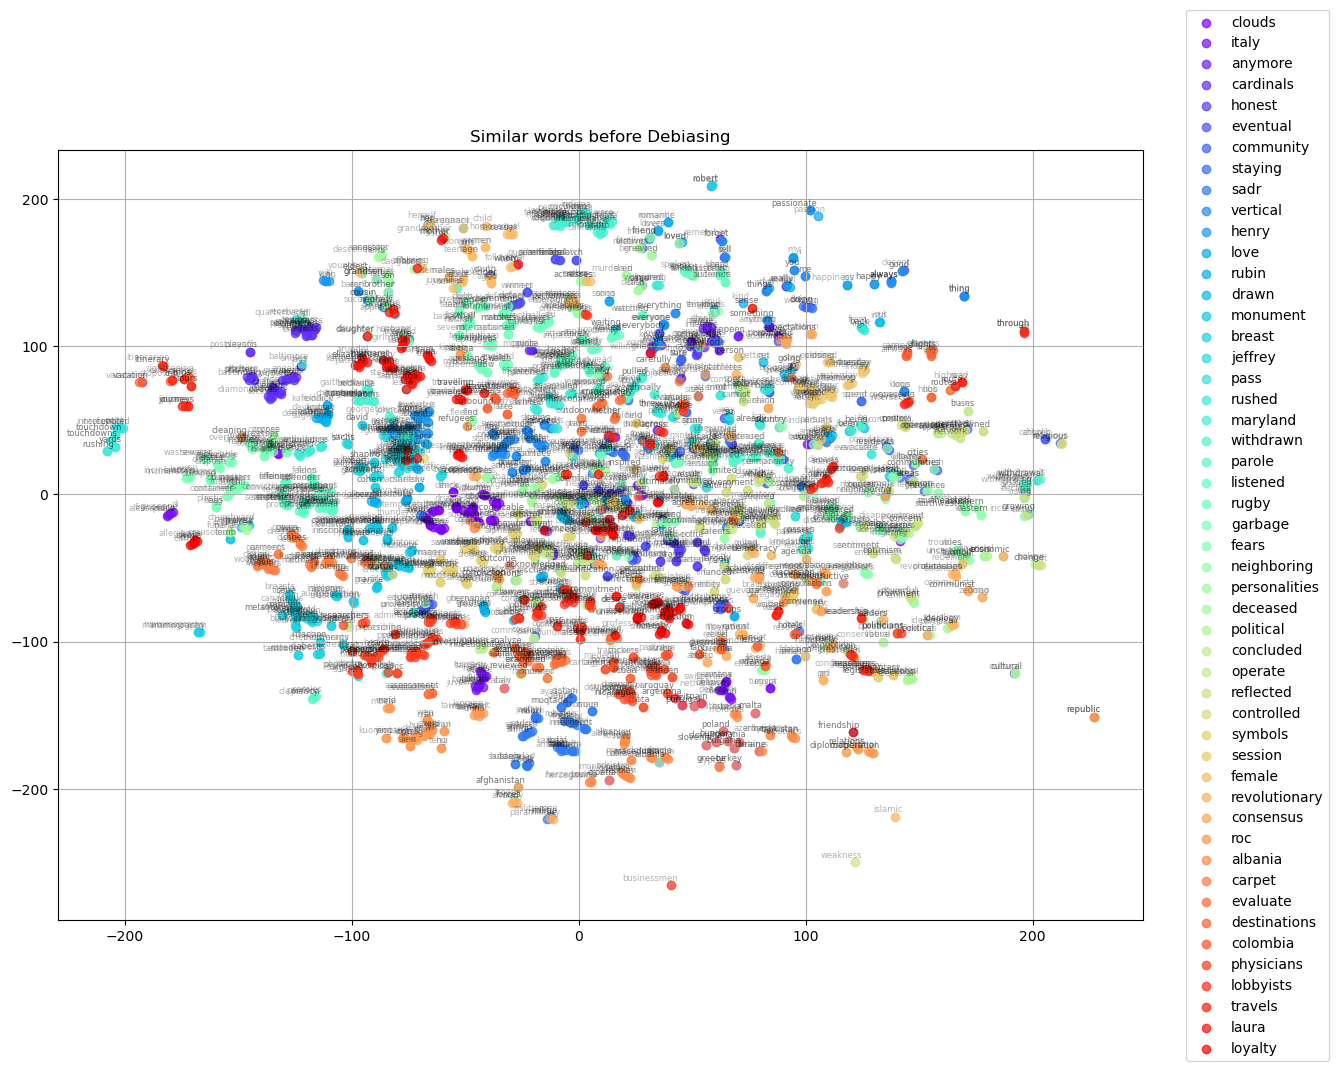

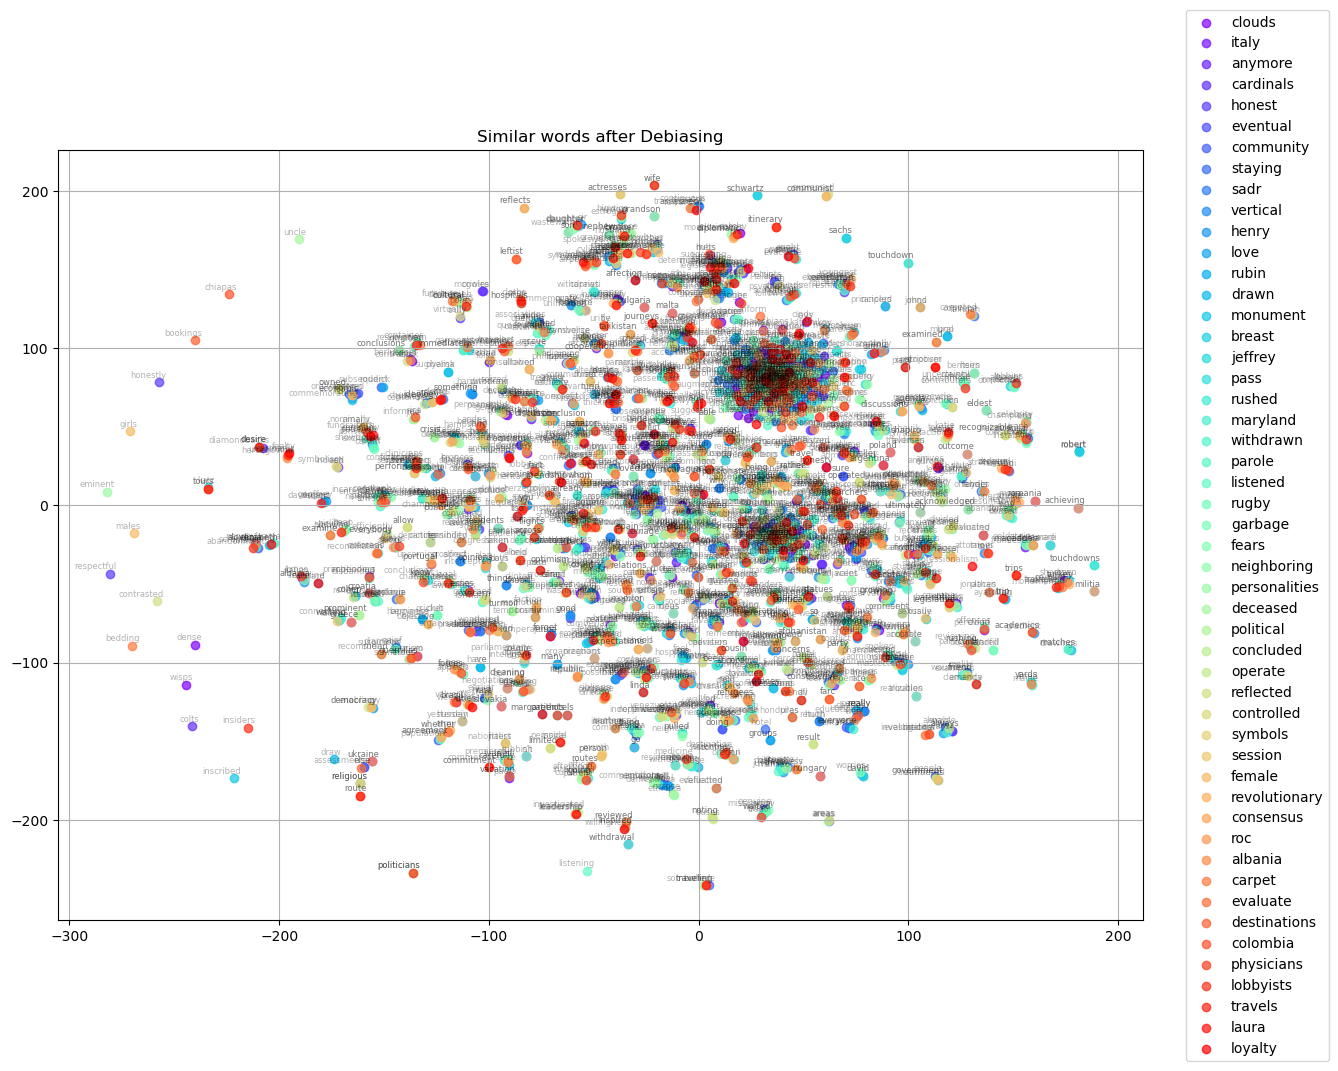

In [36]:
from sklearn.manifold import TSNE
import numpy as np
from Scripts.Visualization import tsne_plot_similar_words

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

#Getting the Gensim models to plot the neighbors
gender_debiased = create_KeyedVectors(deb_vect_gender, deb_vocab_gender, 300)
model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)


keys = random_words
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys, model_original, gender_debiased, 50)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=42)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7, "Figures/Random_words_neighbors_before_debiasing.png")
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7, "Figures/Random_words_neighbors_after_debiasing.png")


In [31]:
distances_original,distances_debiased=get_distance_to_neighbors(k_neigh,
                          dict_vec_cleaned, deb_dict_gender)


In [34]:
df_neigh_distances=get_df_distances(distances_original,distances_debiased)

#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average=df_neigh_distances[['word', 'distance_original', 'distance_debiased']].groupby('word').mean()

#now add a column of the difference between the two mean distances
df_average['difference']=abs(df_average['distance_original']-df_average['distance_debiased'])

df_average=df_average.sort_values(by='difference', ascending=True)
df_average=df_average.rename(columns={'distance_original':'av_distance_original', 'distance_debiased':'av_distance_debiased'})

df_average


av_distance_original  av_distance_debiased  difference
word                                                                 
political                  0.498232              0.681186    0.182954
controlled                 0.580678              0.812845    0.232167
community                  0.528476              0.779067    0.250591
neighboring                0.498668              0.777886    0.279217
session                    0.523522              0.813942    0.290420
drawn                      0.573426              0.865836    0.292410
love                       0.466545              0.762835    0.296290
staying                    0.525873              0.835173    0.309300
travels                    0.578757              0.898465    0.319709
pass                       0.546532              0.883813    0.337281
eventual                   0.598320              0.937224    0.338904
withdrawn                  0.579955              0.919693    0.339738
rugby                      0.511504              0.860846    0.349343
maryland                   0.524736              0.882431    0.357695
consensus                  0.570955              0.929371    0.358415
jeffrey                    0.598944              0.957473    0.358529
personalities              0.577321              0.936129    0.358809
rubin                      0.641006              1.003442    0.362436
operate                    0.509594              0.884787    0.375193
italy                      0.512728              0.890169    0.377441
rushed                     0.554402              0.935864    0.381462
revolutionary              0.570268              0.951768    0.381500
carpet                     0.603155              0.987253    0.384098
henry                      0.526197              0.915242    0.389045
symbols                    0.550504              0.949500    0.398997
roc                        0.579564              0.981558    0.401994
parole                     0.538117              0.943130    0.405013
lobbyists                  0.550289              0.965060    0.414771
concluded                  0.494724              0.920957    0.426232
deceased                   0.552016              0.978408    0.426392
laura                      0.567692              0.997071    0.429380
colombia                   0.481614              0.917797    0.436183
monument                   0.518775              0.956595    0.437820
honest                     0.517177              0.961224    0.444047
albania                    0.497967              0.943847    0.445879
clouds                     0.525757              0.972735    0.446978
destinations               0.538127              0.985740    0.447613
loyalty                    0.534762              0.986657    0.451895
vertical                   0.538035              0.992118    0.454083
female                     0.573404              1.027923    0.454518
breast                     0.518240              0.974957    0.456717
listened                   0.498508              0.966274    0.467765
reflected                  0.491259              0.959436    0.468177
sadr                       0.478778              0.948382    0.469604
fears                      0.420388              0.898294    0.477906
cardinals                  0.472842              0.954379    0.481537
garbage                    0.503171              0.986983    0.483812
evaluate                   0.468296              0.959925    0.491629
physicians                 0.456304              0.987523    0.531219
anymore                    0.353409              0.902240    0.548831

In [35]:
#plot the average distance to neighbors before and after debiasing
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Bar(x=df_average.index,
              y=df_average['av_distance_original'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_average.index,
              y=df_average['av_distance_debiased'], name='Debiased Embeddings'))
#add title
fig.update_layout(title_text='Average cosine distance to neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Words Chosen at Random')
#change y axis title
fig.update_yaxes(title_text='Average Cosine Distance to Neighbors')
#update heigh and width
fig.update_layout(height=500, width=1200)
fig.show()

### Distribution of neighbors test

In [62]:
#get a list with the first value of each tuple in the neighbors list
neighbors_words = []
for random_word in k_neigh:
    for i in range(len(k_neigh[random_word])):
        neighbors_words.append(k_neigh[random_word][i][0])


In [63]:
from Scripts.Evaluation import p_value_perm_neighs

p_value_perm_neighs(random_words, neighbors_words, dict_vec_cleaned,
                    deb_dict_gender)

original mean: 0.012666596077075445
num of samples 250000


100%|██████████| 250000/250000 [1:51:06<00:00, 37.50it/s]  


0.49834

But when running it w¡th another sample of random words, then the P-value was different:

In [70]:
#On a previous attempt, for the following random words, I got a p-value of 0.29

random_words=['athen', 'zindel', 'wyattville', 'fmqb', 'zinfandel', 'nektar',
     'mantovani', 'oper', 'corio', 'pavletic', 'kittanning', 'summeren',
       'monsey', 'chink', 'aurunci', 'robbia', 'frisky', 'meekness',
      'wipo', 'mbomo', 'breakpoints', 'jaegerstaetter', 'wor', 'jetpack',
      'kucharczyk', 'mythago', 'boonton', 'ywain', 'eraiba', 'obiko',
       'bongiovanni', 'zalman', 'stowarzyszenie', 'prophets', 'katju',
       'family', 'tests', 'longmei', 'espagnol', 'tanney', 'luiza',
       'rasin', 'hassim', 'nava', 'warlick', 'monda', 'grimme', 'ansatz',
       'puteaux', 'joanette']

neighbors = get_k_nearest_neighbors(random_words,
                                    dict_vec_cleaned, vocab_cleaned,
                                    vectors_cleaned, word2idx_cleaned, k=50)


array(['athen', 'zindel', 'wyattville', 'fmqb', 'zinfandel', 'nektar',
       'mantovani', 'oper', 'corio', 'pavletic', 'kittanning', 'summeren',
       'monsey', 'chink', 'aurunci', 'robbia', 'frisky', 'meekness',
       'wipo', 'mbomo', 'breakpoints', 'jaegerstaetter', 'wor', 'jetpack',
       'kucharczyk', 'mythago', 'boonton', 'ywain', 'eraiba', 'obiko',
       'bongiovanni', 'zalman', 'stowarzyszenie', 'prophets', 'katju',
       'family', 'tests', 'longmei', 'espagnol', 'tanney', 'luiza',
       'rasin', 'hassim', 'nava', 'warlick', 'monda', 'grimme', 'ansatz',
       'puteaux', 'joanette'], dtype='<U19')

In [282]:
p_value_perm_neighs(random_words, neighbors_words, dict_vec_cleaned,
                    deb_dict_gender)


original mean: -0.01699070871639722
num of samples 250000


100%|██████████| 250000/250000 [17:00<00:00, 245.04it/s]


0.029432

### Distribution of distances test

In [10]:
from Scripts.Evaluation import get_df_random_words_neighbor_analysis_values


df_merged=get_df_random_words_neighbor_analysis_values(
    vocab_cleaned, dict_vec_cleaned, vectors_cleaned, word2idx_cleaned, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, k=50, num_iterations=50, size_random_set=50)


100%|██████████| 50/50 [01:18<00:00,  1.57s/it]
50it [01:18,  1.56s/it]
100%|██████████| 50/50 [01:18<00:00,  1.57s/it]
50it [01:17,  1.55s/it]
100%|██████████| 50/50 [01:18<00:00,  1.57s/it]
50it [01:18,  1.56s/it]
100%|██████████| 50/50 [01:17<00:00,  1.56s/it]
50it [01:17,  1.56s/it]
100%|██████████| 50/50 [01:18<00:00,  1.56s/it]
50it [01:17,  1.55s/it]
100%|██████████| 50/50 [01:18<00:00,  1.57s/it]
50it [01:18,  1.57s/it]
100%|██████████| 50/50 [01:18<00:00,  1.56s/it]
50it [01:17,  1.55s/it]
100%|██████████| 50/50 [01:17<00:00,  1.56s/it]
50it [01:17,  1.55s/it]
100%|██████████| 50/50 [01:17<00:00,  1.56s/it]
50it [01:18,  1.57s/it]
100%|██████████| 50/50 [01:18<00:00,  1.57s/it]
50it [01:18,  1.56s/it]
100%|██████████| 50/50 [01:18<00:00,  1.57s/it]
50it [01:18,  1.56s/it]
100%|██████████| 50/50 [01:17<00:00,  1.56s/it]
50it [01:17,  1.55s/it]
100%|██████████| 50/50 [01:18<00:00,  1.56s/it]
50it [01:18,  1.57s/it]
100%|██████████| 50/50 [01:18<00:00,  1.56s/it]
50it [01:17,  1.

In [12]:
df_merged.to_csv("Data/df_merged_50x50neigh.csv", index=False)

In [13]:
#get the mean values from the dataframe
df_mean=df_merged[['freq','distance_original', 'distance_debiased', 'iteration']].groupby('iteration').agg('mean').reset_index()

#create a long format table of df_mean
df_mean_long=pd.melt(df_mean, id_vars=['iteration'], value_vars=['distance_original', 'distance_debiased', 'freq'])

In [37]:
#plot boxplots for distance original and distance debiased
import plotly.express as px
fig = px.box(df_mean_long[df_mean_long['variable'].str.contains('distance')], x="variable", y="value", points="all",
                title="Average cosine distance to neighbors before and after debiasing",
                labels={"variable": "Cosine Distance", "value": "Average Cosine Distance to Neighbors",
                        'distance_original':"Original Embeddings", 'distance_debiased':"Debiased Embeddings"},
                color_discrete_sequence = ['#636EFA'],
                template='plotly_white', 
                orientation='v',
                height=800, width=600)
#change y-axis range
fig.update_yaxes(range=[0.5, 0.95])
#save the figure
#fig.write_image("Figures/boxplot_distance_original_debiased_50x20neigh.png", engine='kaleido')

fig.show()

In [24]:
#plot boxplots for distance original and distance debiased
import plotly.express as px
fig = px.box(df_mean_long[df_mean_long['variable'].str.contains(
    'freq')], x="variable", y="value", points="all",
    title="Distribution of original neighbors on 50-vicinity after debiasing",
    labels={"variable": "original neighbors", "value": "Frequency"}, 
    template='plotly_white')
#update y-range
fig.update_yaxes(range=[0, 0.1])
fig.show()


In [46]:
#group by iteration to get mean values of all the columns except for the word
mean_df=df_merged.groupby('iteration').mean()

mean_df['diff_distance'] = mean_df['distance_debiased']-mean_df['distance_original']


/var/folders/bh/g_8v28y122j2fc_vq7b3x8cr0000gn/T/ipykernel_72847/628879099.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [52]:
#use plotly to get a histogram of the difference values
import plotly.express as px
fig = px.histogram(mean_df, x="diff_distance", nbins=8,
                     title="Distribution of the difference between the average cosine distance to neighbors before and after debiasing",
                        labels={"diff_distance": "Difference between the average cosine distance to neighbors before and after debiasing"},
                        template='plotly_white'
                        
                        )
#add vertical line for the zero
fig.add_vline(x=0, line_width=3, line_dash="dash", line_color="red")
#update x-axis range
fig.update_xaxes(range=[0.25, 0.35])
#get the borders of the bins


fig.show()


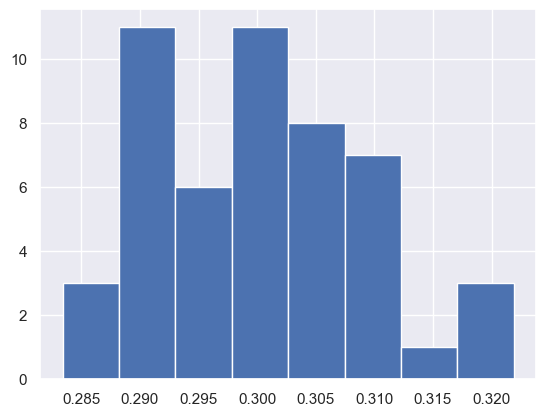

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

#get the the distribution of the values
sns.set()
plt.hist(mean_df['diff_distance'], bins=8)
plt.show()


In [53]:
#get quantiles of the mean_df['diff_distance']
q1,_,q3=mean_df['diff_distance'].quantile([0.25,0.5,0.75])
print(q1,q3)

0.2920119708509775 0.3048202917787517


### Punctuation test


In [55]:
# Getting a limited vocabulary to debias the embeddings.
vocab_punct, vectors_punct, word2idx_punct, dict_vec_punct = glove.limit_vocab(vectors, word2idx, vocab, exclude=vocab_cleaned, exclude_punct=False)
print('Shape of the vectors of words with punctuation marks or numbers:', vectors_punct.shape)
print(type(vectors_punct))


Size of limited vocabulary: 72815
Shape of the vectors of words with punctuation marks or numbers: (72815, 300)
<class 'numpy.ndarray'>


In [56]:
#add the vectors_punct to the deb_vect_gender
all_vectors = np.vstack([deb_vect_gender, vectors_punct])
all_words = deb_vocab_gender+vocab_punct
#paste the two dictionaries together
w2i_all = {w: i for i, w in enumerate(all_words)}
dict_all=get_debiased_dict(all_vectors, w2i_all)



In [61]:
df_punct = get_df_random_words_neighbor_analysis_values(
    vocab_punct, dict_vectors, vectors, word2idx,
    dict_all, all_words, all_vectors, w2i_all,
    k=50, num_iterations=2, size_random_set=50)


100%|██████████| 50/50 [00:21<00:00,  2.33it/s]
50it [01:37,  1.94s/it]
100%|██████████| 50/50 [00:21<00:00,  2.33it/s]
50it [01:36,  1.93s/it]


In [62]:
df_punct


word  previous_neighbours  freq  distance_original  \
0                   66                    0   0.0           1.069320   
1      self-immolation                    0   0.0           0.891765   
2                 u-23                    0   0.0           0.960715   
3            inter-war                    0   0.0           0.935247   
4                106.8                    0   0.0           0.864052   
..                 ...                  ...   ...                ...   
45      german-english                    0   0.0           0.864026   
46               10:09                    0   0.0           0.877368   
47  steelton-highspire                    0   0.0           0.833921   
48          first-team                    0   0.0           0.979865   
49                  -1                    0   0.0           0.913049   

    distance_debiased  iteration  
0            1.069320          0  
1            0.891765          0  
2            0.960715          0  
3            0.935247          0  
4            0.864052          0  
..                ...        ...  
45           0.864026          1  
46           0.877368          1  
47           0.833921          1  
48           0.979865          1  
49           0.913049          1  

[100 rows x 6 columns]

In [66]:
from Scripts.Evaluation import get_k_nearest_neighbors, get_distance_to_neighbors, get_frequency_original_neighbors, get_df_distances
random_words = np.random.choice(vocab_punct[:10000], size=50)
#get the neighbors of the original vectors
k_neigh_original= get_k_nearest_neighbors(random_words, dict_vectors, vocab, vectors, word2idx, k=50)
#list_neigh_original=get_list_neighbors(k_neigh_original)

#get the distances to neighbors before and after debiasing
distances_original, distances_debiased = get_distance_to_neighbors(k_neigh_original,
                                                                   dict_vectors, dict_all)
#get dataframe of distances from distances_original and distances_debiased
df_neigh_distances=get_df_distances(distances_original,distances_debiased)
#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average=df_neigh_distances[['word', 'distance_original', 'distance_debiased']].groupby('word').mean()
        
#frequencies of neighbors
neig_freq2 = get_frequency_original_neighbors(
    random_words, k_neigh_original, dict_all, all_words, all_vectors, w2i_all, neighbours_num=50)
df2 = pd.DataFrame(neig_freq2, columns=['word', 'previous_neighbours', 'freq'])
#merge the two dataframes on the word column
#merge df and df average on word
df_merged_punct=df2.merge(df_average, on='word')
 #df=pd.concat([df,df_merged], axis=1, keys='words')

100%|██████████| 50/50 [01:56<00:00,  2.34s/it]
50it [01:38,  1.98s/it]


In [67]:
df_merged_punct

word  previous_neighbours  freq  distance_original  \
0        toronto-area                   29  0.58           0.583388   
1               24.94                   29  0.58           0.458226   
2               422.5                   40  0.80           0.520629   
3              115.20                   35  0.70           0.410418   
4         ball-shaped                   16  0.32           0.555910   
5               99-84                   38  0.76           0.425479   
6           1115-1234                   30  0.60           0.523084   
7               96.34                   35  0.70           0.372522   
8            165-year                   32  0.64           0.456433   
9             759,000                   36  0.72           0.510457   
10        re-exported                   22  0.44           0.533333   
11          34-second                   34  0.68           0.522880   
12                127                   25  0.50           0.197412   
13              7,820                   36  0.72           0.465823   
14      juan-les-pins                   21  0.42           0.497889   
15         1,200-mile                   29  0.58           0.519823   
16              1,171                   26  0.52           0.471153   
17     stone-campbell                   10  0.20           0.537136   
18             11,950                   41  0.82           0.499099   
19               31-7                   26  0.52           0.363715   
20               pge2                   11  0.22           0.540820   
21              58.73                   37  0.74           0.437521   
22         7,000-mile                   42  0.84           0.557840   
23           x-statix                    7  0.14           0.589876   
24  seven-dimensional                    8  0.16           0.522735   
25    nord-américaine                    7  0.14           0.529997   
26    nord-américaine                    7  0.14           0.529997   
27              3,755                   40  0.80           0.496075   
28            1954/55                   27  0.54           0.491918   
29              vxe-6                   20  0.40           0.644150   
30                505                   24  0.48           0.332899   
31              1.058                   45  0.90           0.451604   
32              54.21                   32  0.64           0.474035   
33               6:42                   27  0.54           0.315820   
34         yōshin-ryū                   18  0.36           0.513216   
35              444th                   27  0.54           0.499123   
36       blood-soaked                   19  0.38           0.615018   
37              1,705                   26  0.52           0.501781   
38          carbon-13                   20  0.40           0.593237   
39               rc-7                   16  0.32           0.654970   
40               1/32                   26  0.52           0.448713   
41             o-ring                   15  0.30           0.657630   
42                6-8                   24  0.48           0.414011   
43    self-governance                   22  0.44           0.614644   
44              10/32                   25  0.50           0.421044   
45              29.89                   25  0.50           0.454558   
46       5,000-strong                   25  0.50           0.553224   
47              12.53                   34  0.68           0.463815   
48            yat-sen                    6  0.12           0.641977   
49           sky-high                   13  0.26           0.562718   

    distance_debiased  
0            0.689100  
1            0.458226  
2            0.520629  
3            0.410418  
4            0.726705  
5            0.425479  
6            0.590908  
7            0.372522  
8            0.461592  
9            0.558770  
10           0.684403  
11           0.522880  
12           0.197412  
13           0.465823  
14           0.666878  
15         

In [68]:
#plot the average distance to neighbors before and after debiasing
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Bar(x=df_merged_punct['word'],
              y=df_merged_punct['distance_original'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_merged_punct['word'],
              y=df_merged_punct['distance_debiased'], name='Debiased Embeddings'))
#add title
fig.update_layout(
    title_text='Average cosine distance to neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Words Chosen at Random from excluded vocabulary')
#change y axis title
fig.update_yaxes(title_text='Average Cosine Distance to Neighbors')

fig.show()


In [69]:
model_debiased_punct = create_KeyedVectors(all_vectors, all_words, 300)


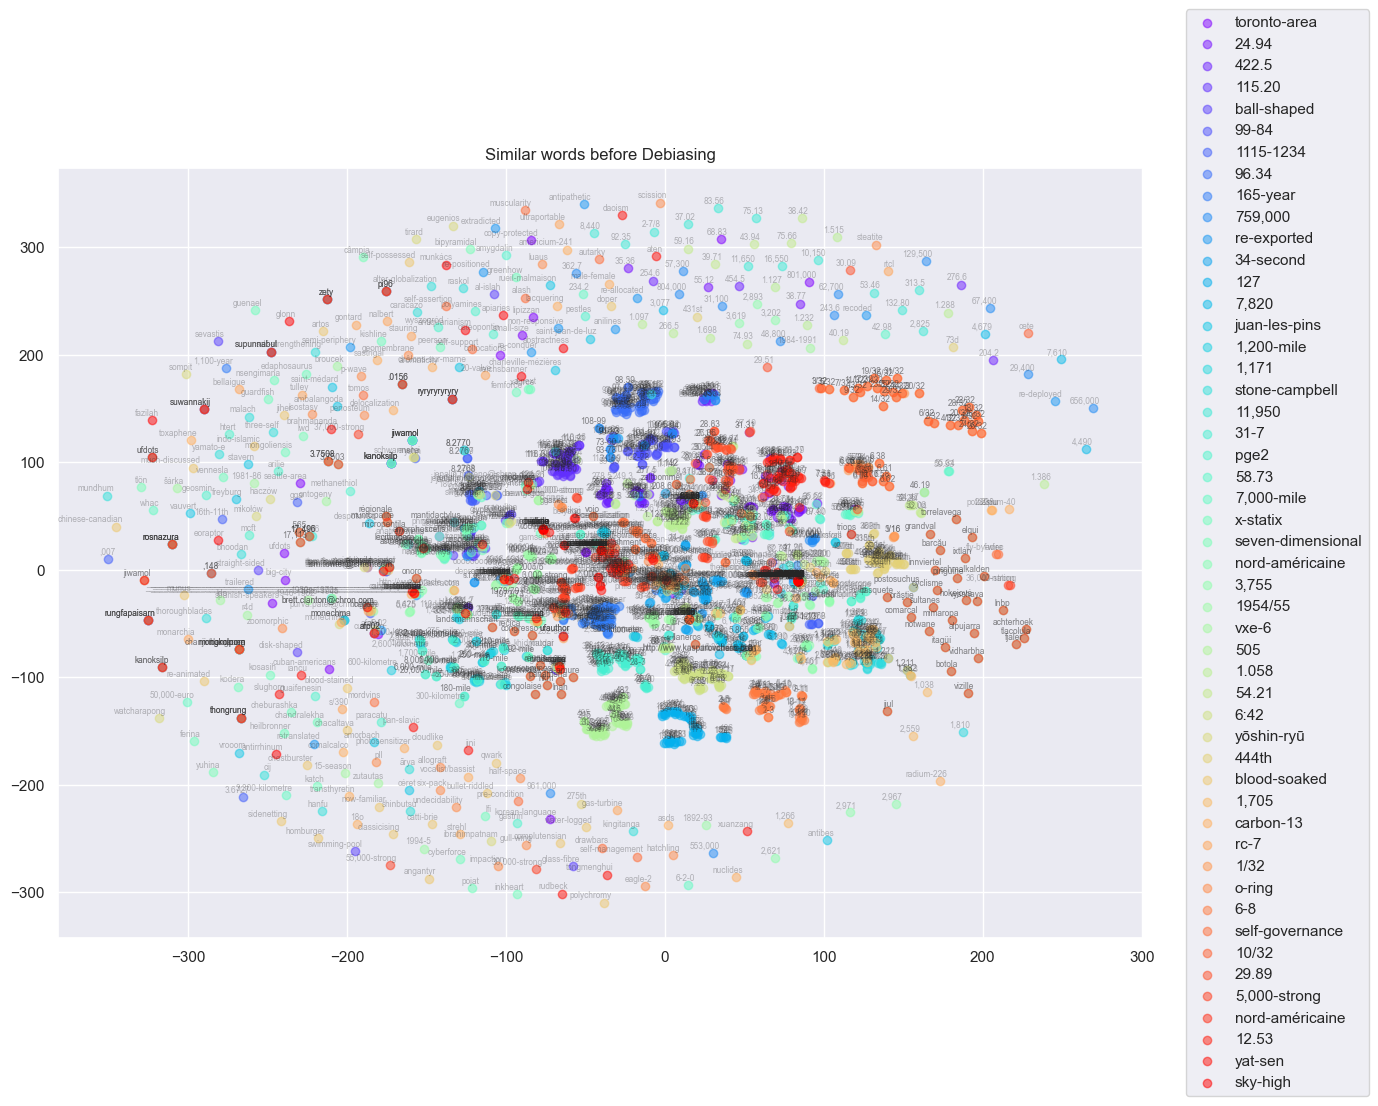

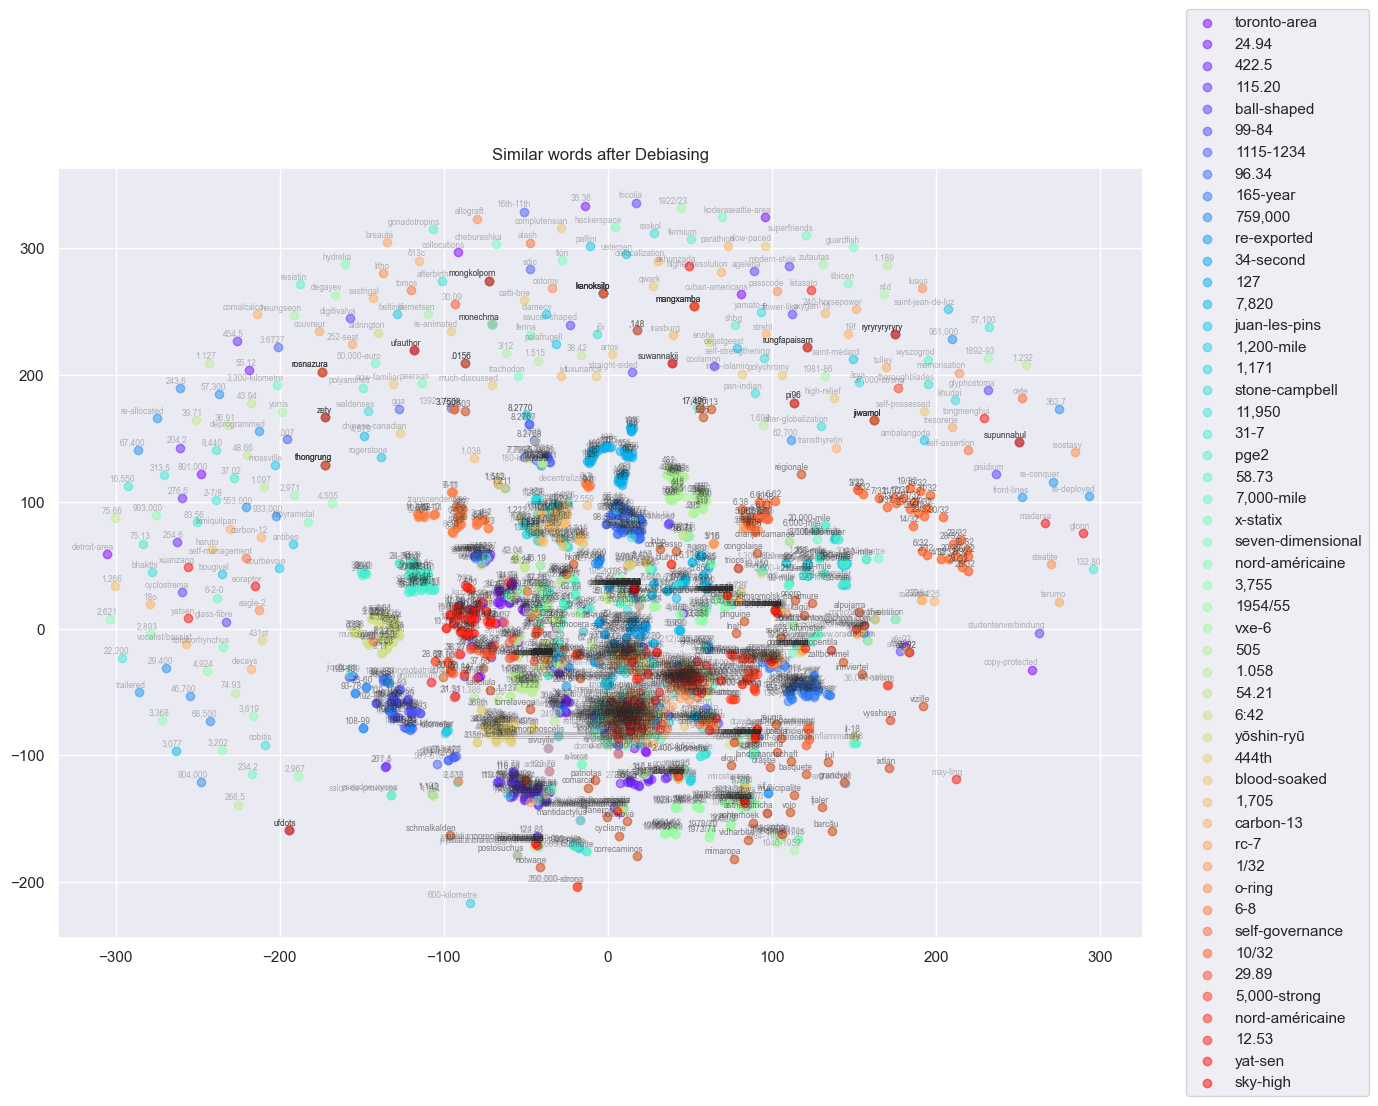

In [71]:
from sklearn.manifold import TSNE
import numpy as np
from Scripts.Visualization import tsne_plot_similar_words
from Scripts.Evaluation import get_embeddings_neighbors

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
keys = random_words
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys, glove.model, model_debiased_punct, 50)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=42)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.5)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.5)


### Neutral words

In [109]:
gender_direction = identify_bias_subspace(
    dict_vectors, def_set_gender, 1, centralizing=True)

direct_gender_bias_original = compute_similarity_to_bias_direction(
    dict_vec_cleaned, gender_direction)



Length of vectors set: 22
Running PCA with 1 components


In [124]:
#transform the values of the direct_gender_bias_original dictionary to float
for word, value in direct_gender_bias_original.items():
    direct_gender_bias_original[word]=float(value)

In [156]:
orig_neutral = [word for word in direct_gender_bias_original.keys()
              if np.abs(direct_gender_bias_original[word])<0.001]

print('words closer to be neutral in original embeddings:',len(orig_neutral))
print('first 10 neutral words:', orig_neutral[:10])

words closer to be neutral in original embeddings: 2984
first 10 netral words: ['my', 'population', 'california', 'products', 'angeles', 'killing', 'cents', 'details', 'museum', 'separate']


In [152]:
len(neutral)


2984

In [157]:
from Scripts.Evaluation import get_k_nearest_neighbors, get_distance_to_neighbors, get_frequency_original_neighbors, get_df_distances
random_neutral = np.random.choice(orig_neutral, size=50)
#get the neighbors of the original vectors
k_neigh_neutral = get_k_nearest_neighbors(
    random_neutral, dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=50)
#list_neigh_original=get_list_neighbors(k_neigh_original)

#get the distances to neighbors before and after debiasing
distances_original_nt, distances_debiased_nt = get_distance_to_neighbors(k_neigh_neutral,
                                                                   dict_vec_cleaned, deb_dict_gender)
#get dataframe of distances from distances_original and distances_debiased
df_neigh_distances_nt = get_df_distances(distances_original_nt, distances_debiased_nt)
#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average_nt = df_neigh_distances_nt[[
    'word', 'distance_original', 'distance_debiased']].groupby('word').mean()

#frequencies of neighbors
neig_freq_nt = get_frequency_original_neighbors(
    random_neutral, k_neigh_neutral, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=50)
df2_nt = pd.DataFrame(neig_freq_nt, columns=[
                   'word', 'previous_neighbours', 'freq'])
#merge the two dataframes on the word column
#merge df and df average on word
df_merged_neutral = df2_nt.merge(df_average_nt, on='word')
#df=pd.concat([df,df_merged], axis=1, keys='words')


100%|██████████| 50/50 [01:21<00:00,  1.63s/it]
50it [01:21,  1.62s/it]


In [158]:
#plot the average distance to neighbors before and after debiasing
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Bar(x=df_merged_neutral['word'],
              y=df_merged_neutral['distance_original'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_merged_neutral['word'],
              y=df_merged_neutral['distance_debiased'], name='Debiased Embeddings'))
#add title
fig.update_layout(
    title_text='Average cosine distance to neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Words Chosen at Random from excluded vocabulary')
#change y axis title
fig.update_yaxes(title_text='Average Cosine Distance to Neighbors')

fig.show()


In [159]:
import plotly_express as px
#plot the frequency of the original neighbours in the debiased network in a horizontal bar chart

fig = px.bar(df2_nt, x='word', y='freq', title='Proportion of original 50 neighbours in the debiased k-vicinity of each word',
             labels={'freq': 'Proportion', 'word': 'Word'},
             height=500, width=1000)
#update the layout of the plot: update the y axis to be between 0 and 0.5 and the x axis to include all ticks
fig.update_layout(yaxis=dict(range=[0, 0.5]))

fig.show()


In [160]:
model_original= create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)
model_debiased_gender=create_KeyedVectors(deb_vect_gender,deb_vocab_gender,300)

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Matplotlib currently does not support Devanagari natively.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from current font.



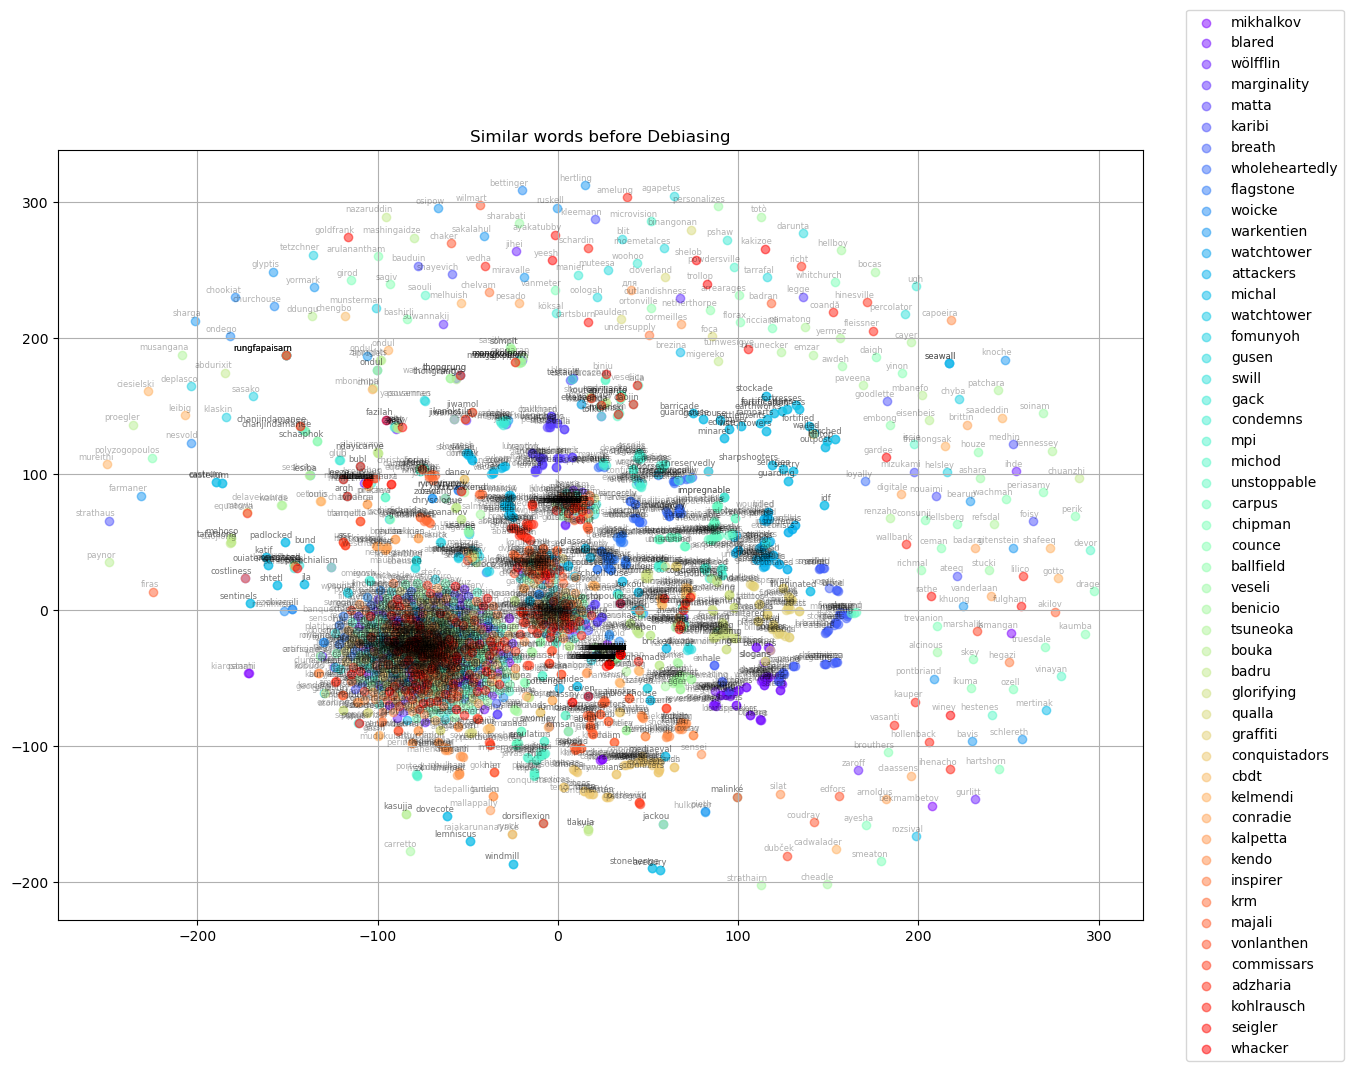

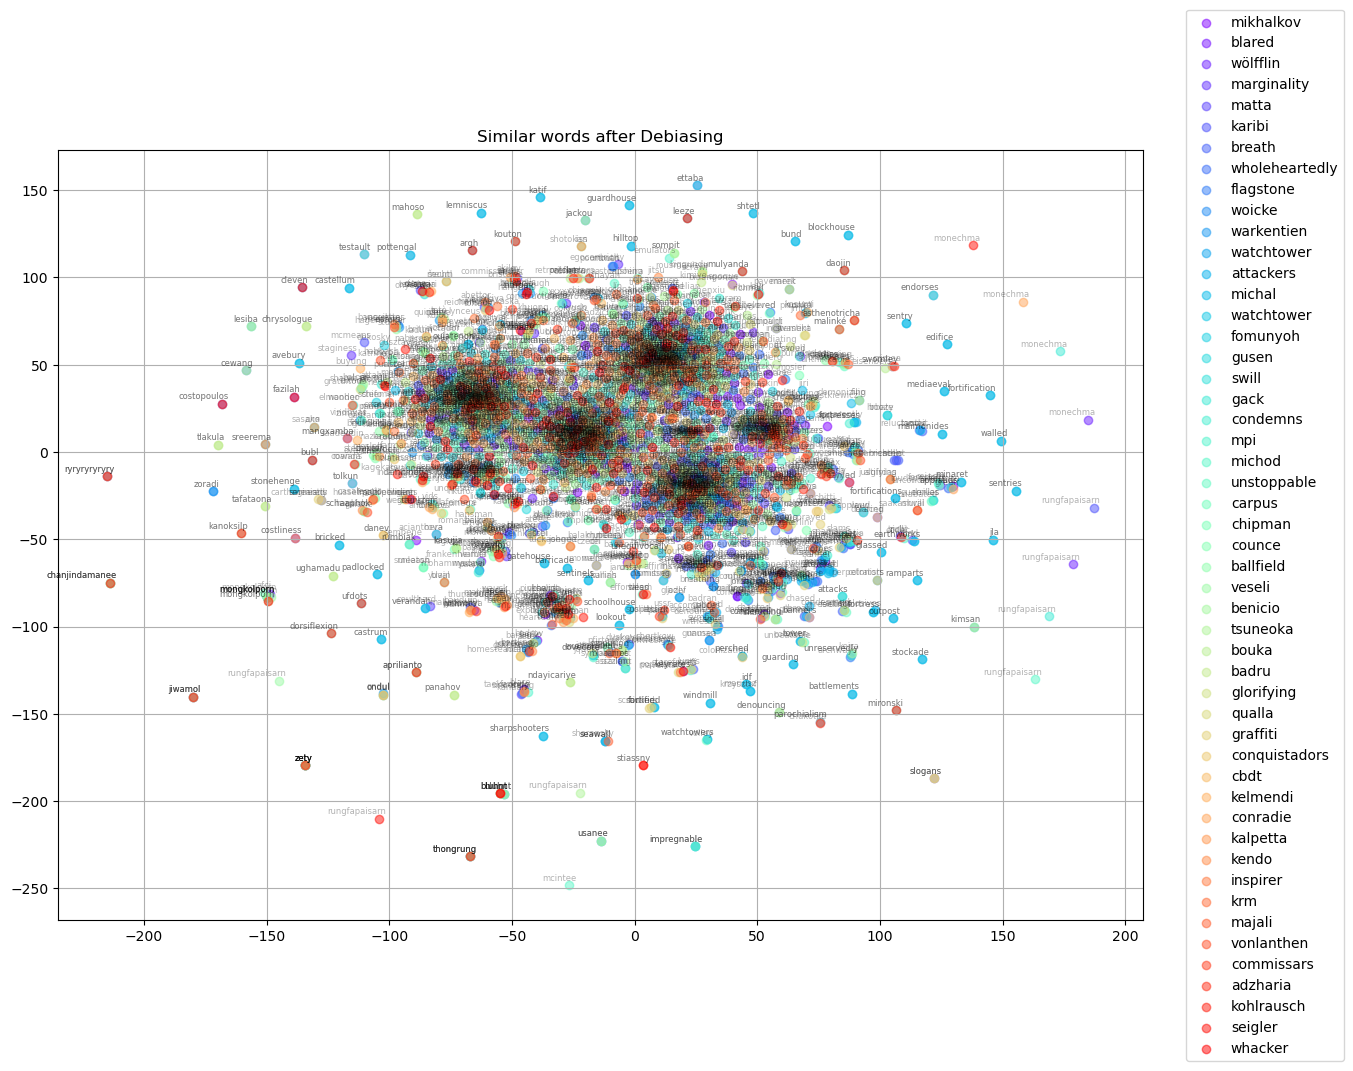

In [161]:
from sklearn.manifold import TSNE
import numpy as np
from Scripts.Visualization import tsne_plot_similar_words
from Scripts.Evaluation import get_embeddings_neighbors

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
keys = random_neutral
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys, model_original, model_debiased_gender, 50)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=42)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.5)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.5)


In [44]:
#get a list with the first value of each tuple in the neighbors list
neighbors_words_nt = []
for random_word in k_neigh_neutral:
    for i in range(len(k_neigh_neutral[random_word])):
        neighbors_words_nt.append(k_neigh_neutral[random_word][i][0])


In [45]:
pval_nt = p_value_perm_neighs(random_neutral, neighbors_words_nt, dict_vec_cleaned,
                                 deb_dict_gender)


original mean: 0.023045335562509327
num of samples 250000


100%|██████████| 250000/250000 [1:52:27<00:00, 37.05it/s]  


In [49]:
pval_nt


0.495824

### Occupations

In [50]:
#get the occupations taht are in the vocab_cleaned
occupations_in_vocab = [word for word in occupations if word in vocab_cleaned]
print(len(occupations_in_vocab))

#get the neighbors of the original vectors
k_neigh_original_g = get_k_nearest_neighbors(
    occupations_in_vocab, dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=50)
list_neigh_original_g = get_list_neighbors(k_neigh_original_g)
#get the neighbors of the debiased vectors
k_neigh_debiased_g = get_k_nearest_neighbors(
    occupations_in_vocab, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, k=50)


59


100%|██████████| 59/59 [01:33<00:00,  1.59s/it]


In [55]:
#create gender word list for word in both k_neigh_debiased.keys() and k_neigh_original_g.keys()
neutral_words= [word for word in k_neigh_debiased.keys() if word in k_neigh_original_g.keys()]

In [62]:
#get the distances to neighbors before and after debiasing
distances_original_g, distances_debiased_g = get_distance_to_neighbors(k_neigh_original_g,
                                                                       dict_vec_cleaned, deb_dict_gender)
#get dataframe of distances from distances_original and distances_debiased
df_neigh_distances = get_df_distances(
    distances_original_g, distances_debiased_g)
#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average_occ = df_neigh_distances[[
    'word', 'distance_original', 'distance_debiased']].groupby('word').mean()

#frequencies of neighbors
neig_freq_occ = get_frequency_original_neighbors(
    occupations_in_vocab, k_neigh_original_g, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=50)
df2_occ = pd.DataFrame(neig_freq_occ, columns=['word', 'previous_neighbours', 'freq'])
#merge the two dataframes on the word column
#merge df and df average on word
df_merged_occ = df2_occ.merge(df_average_occ, on='word')
#df=pd.concat([df,df_merged], axis=1, keys='words')


59it [01:35,  1.62s/it]


In [63]:
import plotly_express as px
#plot the frequency of the original neighbours in the debiased network in a horizontal bar chart

fig = px.bar(df2_occ, x='word', y='freq', title='Proportion of original 50 neighbours in the debiased k-vicinity of each word',
             labels={'freq': 'Proportion', 'word': 'Word'},
             height=500, width=1000)
#update the layout of the plot: update the y axis to be between 0 and 0.5 and the x axis to include all ticks
fig.update_layout(yaxis=dict(range=[0, 0.5]))

fig.show()


In [64]:
#plot the average distance to neighbors before and after debiasing
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Bar(x=df_merged_neutral['word'],
              y=df_merged_neutral['distance_original'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_merged_neutral['word'],
              y=df_merged_neutral['distance_debiased'], name='Debiased Embeddings'))
#add title
fig.update_layout(
    title_text='Average cosine distance to neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Words Chosen at Random from excluded vocabulary')
#change y axis title
fig.update_yaxes(title_text='Average Cosine Distance to Neighbors')

fig.show()

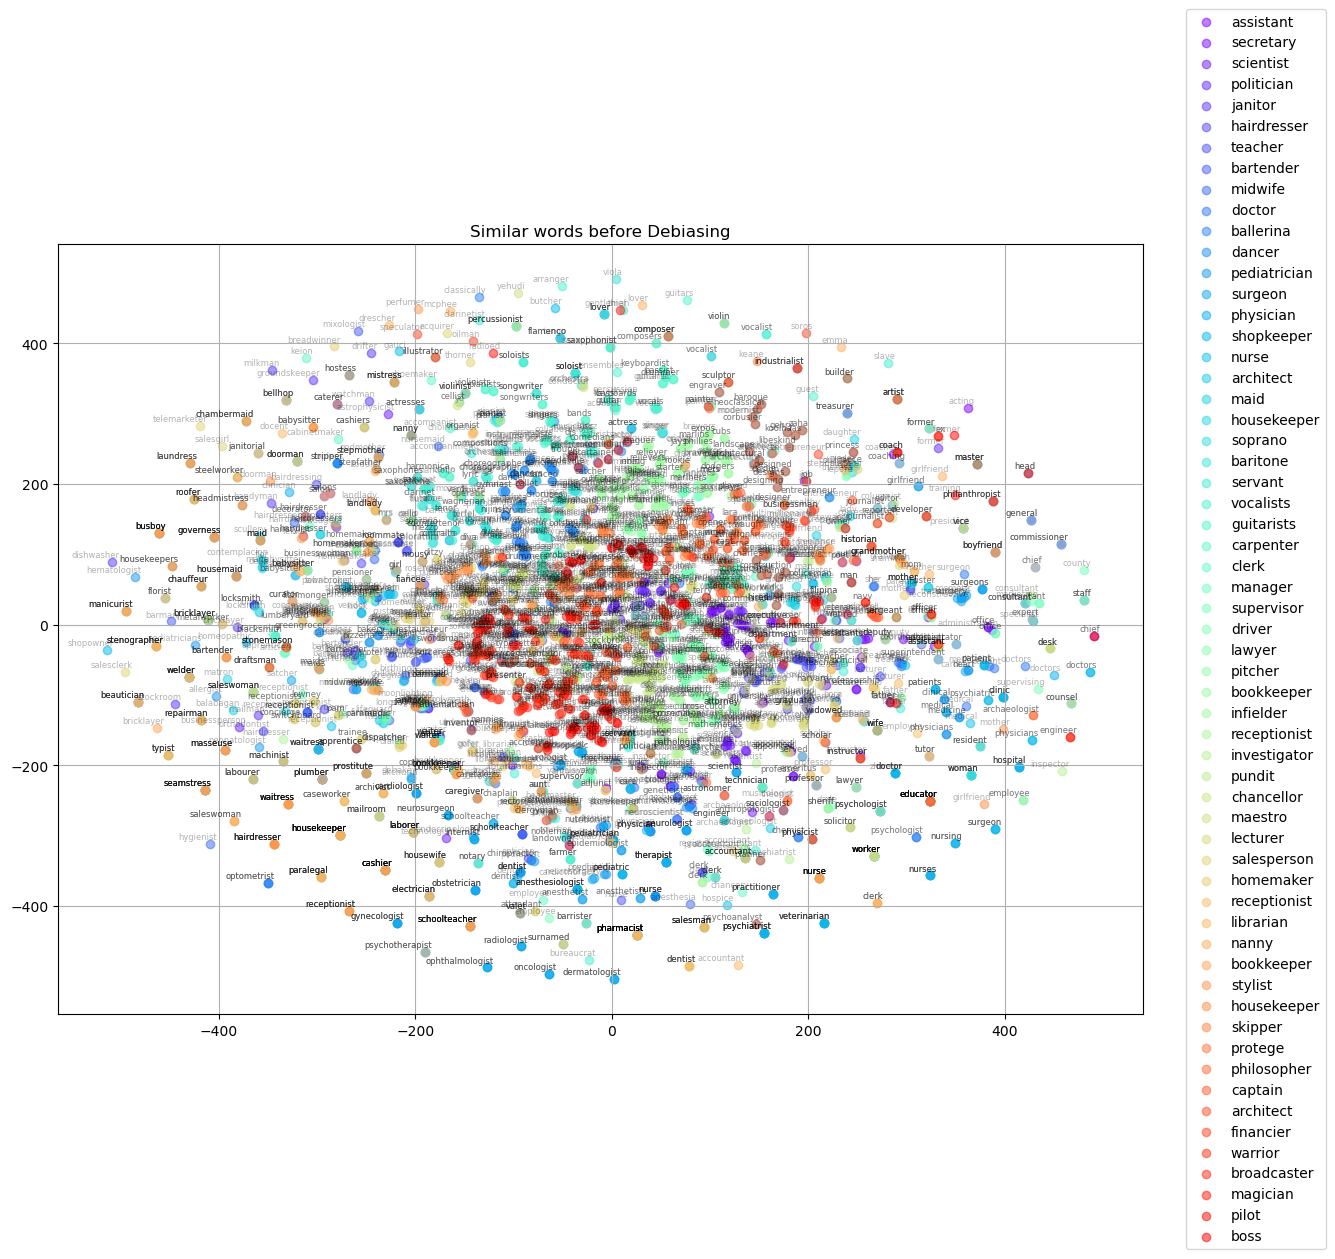

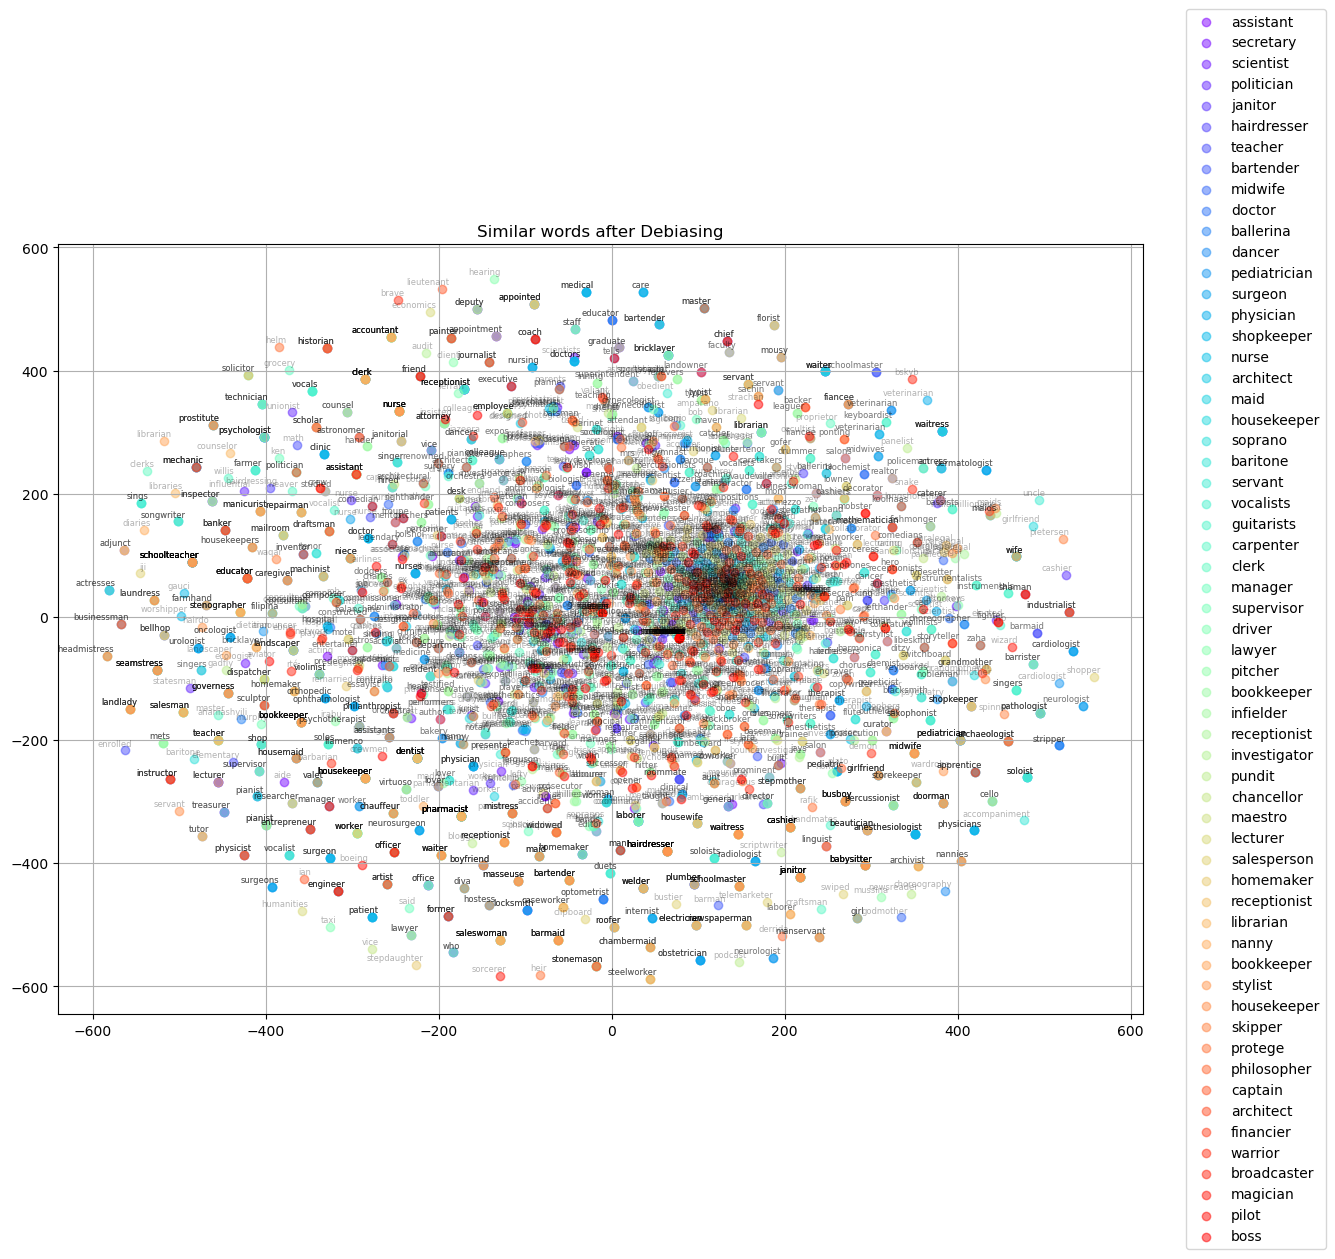

In [66]:
from sklearn.manifold import TSNE
import numpy as np
from Scripts.Visualization import tsne_plot_similar_words
from Scripts.Evaluation import get_embeddings_neighbors

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
keys = occupations_in_vocab
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys, model_original, model_debiased_gender, 50)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=42)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.5)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.5)


In [68]:

def bias_by_neighbors(word_list, dict_vect, vocab, vectors, w2i, neighbours_num=100):

    tuples = []
    for word in tqdm(word_list):

        _,top = get_topK_neighbors(
            word, dict_vect, vocab, vectors, w2i, k=neighbours_num)

        m = 0
        f = 0
        for t in top:
            if simple_gender_bias_original[t] > 0:
                f += 1
            else:
                m += 1

        tuples.append(
            (word, simple_gender_bias_original[word], gender_bias_after_debiasing[word], f, m))

    return tuples


In [71]:
bias_neigh = bias_by_neighbors(occupations_in_vocab, deb_dict_gender, deb_vocab_gender,
                  deb_vect_gender, deb_word2idx_gender, neighbours_num=50)


100%|██████████| 59/59 [01:35<00:00,  1.62s/it]


In [72]:
#get a dataframe of the bias by neighbors (bias_neigh)
df_bias_neigh=pd.DataFrame(bias_neigh, columns=['word', 'bias_original', 'bias_debiased', 'f', 'm'])
df_bias_neigh['diff_neigh']=df_bias_neigh['f']-df_bias_neigh['m']




In [73]:
df_bias_neigh


word  bias_original  bias_debiased   f   m  diff_neigh
0      assistant      -0.065951      -0.027665  13  37         -24
1      secretary      -0.058412       0.013040   8  42         -34
2      scientist      -0.075615       0.029652  16  34         -18
3     politician      -0.092756      -0.009252  11  39         -28
4        janitor      -0.012418      -0.034179  29  21           8
5    hairdresser       0.156028      -0.012090  29  21           8
6        teacher       0.043036       0.033999  20  30         -10
7      bartender       0.045976      -0.022241  18  32         -14
8        midwife       0.211095      -0.009966  34  16          18
9         doctor       0.003835       0.013995  12  38         -26
10     ballerina       0.243311       0.411772  34  16          18
11        dancer       0.156638      -0.419075  30  20          10
12  pediatrician       0.115340       0.029326  27  23           4
13       surgeon      -0.045878       0.045211  16  34         -18
14     physician      -0.061494      -0.008957   9  41         -32
15    shopkeeper       0.000090      -0.005154  27  23           4
16         nurse       0.187380       0.028587  15  35         -20
17     architect      -0.103531      -0.030053  13  37         -24
18          maid       0.189010      -0.417248  36  14          22
19   housekeeper       0.180631       0.007171  26  24           2
20       soprano       0.179808      -0.008862  17  33         -16
21      baritone      -0.029812      -0.396677  26  24           2
22       servant      -0.032303      -0.001536  17  33         -16
23     vocalists       0.125470      -0.011701  30  20          10
24    guitarists      -0.045485      -0.017798  30  20          10
25     carpenter      -0.017176       0.017039  18  32         -14
26         clerk       0.012428      -0.009814  24  26          -2
27       manager      -0.135291       0.032888  12  38         -26
28    supervisor       0.079018       0.047344  12  38         -26
29        driver      -0.089208      -0.014199   6  44         -38
30        lawyer      -0.038840       0.005068   8  42         -34
31       pitcher      -0.146017       0.016872  13  37         -24
32    bookkeeper       0.060888      -0.044456  28  22           6
33     infielder      -0.112174       0.024298  26  24           2
34  receptionist       0.169494      -0.056358  25  25           0
35  investigator      -0.015325       0.017255  22  28          -6
36        pundit      -0.016963       0.006606  22  28          -6
37    chancellor      -0.027802      -0.018355  15  35         -20
38       maestro      -0.067613      -0.015412  31  19          12
39      lecturer      -0.014610      -0.020184  17  33         -16
40   salesperson       0.053806      -0.039657  35  15          20
41     homemaker       0.204461       0.004034  20  30         -10
42  receptionist       0.169494      -0.056358  25  25           0
43     librarian       0.100899      -0.020090  23  27          -4
44         nanny       0.181539       0.007216  15  35         -20
45    bookkeeper       0.060888      -0.044456  28  22           6
46       stylist       0.179165      -0.014029  24  26          -2
47   housekeeper       0.180631       0.007171  26  24           2
48       skipper      -0.099069       0.020075  15  35         -20
49       protege      -0.033505      -0.038677  30  20          10
50   philosopher      -0.094847       0.011105  14  36         -22
51       captain      -0.109352       0.004064   7  43         -36
52     architect      -0.103531      -0.030053  13  37         -24
53     financier      -0.121391      -0.043628  24  26          -2
54       warrior       0.054117       0.061111  17  33         -16
55   broadcaster      -0.093981       0.042416  23  27          -4
56      magician      -0.047643       0.007665  23  27          -4
57         pilot      -0.042544       0.005960  13  37         -24
58          boss      -0.108633       0.000979  13  37     

In [77]:
#plot bias by neighbors side by side to the bias_original and bias_debiased
fig = go.Figure()
fig.add_trace(go.Bar(x=df_bias_neigh['word'],
                     y=df_bias_neigh['bias_original'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_bias_neigh['word'],
                     y=df_bias_neigh['bias_debiased'], name='Debiased Embeddings'))

#add title
fig.update_layout(
    title_text='Bias scores and biased Neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Neutral Occupations')
#change y axis title
fig.update_yaxes(title_text='Bias by Neighbors')
fig.show()

fig1 = go.Figure()
#add a line with the diff_neigh column
fig1.add_trace(go.Scatter(x=df_bias_neigh['word'],
                         y=df_bias_neigh['diff_neigh'], name='Bias by Neighbors', mode='markers'))
fig1.show()


In [75]:
def get_words_from_pairs(definitional_pairs):
  """"  
  Gets the words from the pairs of words
  ----
  :param definitional_pairs: list of pairs of words
  :return: list of words
  """
  # Turning the pairs into words to add afterwards to the vocabulary
  definitional_list = []
  for pair in definitional_pairs:
    for word in pair:
      definitional_list.append(word)
  return definitional_list


In [95]:
equalized_words=get_words_from_pairs(equalizing_lists['gender'])

In [98]:
len(equalized_words)

104

## Gendered Words:


In [162]:
orig_biased=[word for word in direct_gender_bias_original.keys() 
              if np.abs(direct_gender_bias_original[word])>0.25]

print('words closer to be biased in original embeddings:', len(orig_biased))
print('first 10 biased words:', orig_biased[:10])


words closer to be biased in original embeddings: 2444
first 10 biased words: ['he', 'his', 'she', 'her', 'women', 'john', 'man', 'george', 'chairman', 'himself']


In [163]:
from Scripts.Evaluation import get_k_nearest_neighbors, get_distance_to_neighbors, get_frequency_original_neighbors, get_df_distances
random_biased = np.random.choice(orig_biased, size=50)
#get the neighbors of the original vectors
k_neigh_biased = get_k_nearest_neighbors(
    random_biased, dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=50)
#list_neigh_original=get_list_neighbors(k_neigh_original)

#get the distances to neighbors before and after debiasing
distances_original_bs, distances_debiased_bs = get_distance_to_neighbors(k_neigh_biased,
                                                                         dict_vec_cleaned, deb_dict_gender)
#get dataframe of distances from distances_original and distances_debiased
df_neigh_distances_bs = get_df_distances(
    distances_original_bs, distances_debiased_bs)
#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average_bs = df_neigh_distances_bs[[
    'word', 'distance_original', 'distance_debiased']].groupby('word').mean()

#frequencies of neighbors
neig_freq_bs = get_frequency_original_neighbors(
    random_biased, k_neigh_biased, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=50)
df2_bs = pd.DataFrame(neig_freq_bs, columns=[
    'word', 'previous_neighbours', 'freq'])
#merge the two dataframes on the word column
#merge df and df average on word
df_merged_biased = df2_bs.merge(df_average_bs, on='word')
#df=pd.concat([df,df_merged], axis=1, keys='words')


100%|██████████| 50/50 [01:21<00:00,  1.63s/it]
50it [01:20,  1.61s/it]


In [168]:
#remove duplicates form df_merged_biased
df_merged_biased.drop_duplicates(subset='word', inplace=True)


In [169]:
#plot the average distance to neighbors before and after debiasing
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Bar(x=df_merged_biased['word'],
              y=df_merged_biased['distance_original'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_merged_biased['word'],
              y=df_merged_biased['distance_debiased'], name='Debiased Embeddings'))
#add title
fig.update_layout(
    title_text='Average cosine distance to neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Words Chosen at Random from excluded vocabulary')
#change y axis title
fig.update_yaxes(title_text='Average Cosine Distance to Neighbors')
#change width and height of figure
fig.update_layout(
    autosize=False,
    width=1200,
    height=500,)

fig.show()


In [170]:
import plotly_express as px
#plot the frequency of the original neighbours in the debiased network in a horizontal bar chart

fig = px.bar(df2_nt, x='word', y='freq', title='Proportion of original 50 neighbours in the debiased k-vicinity of each word',
             labels={'freq': 'Proportion', 'word': 'Word'},
             height=500, width=1000)
#update the layout of the plot: update the y axis to be between 0 and 0.5 and the x axis to include all ticks
fig.update_layout(yaxis=dict(range=[0, 0.5]))

fig.show()


In [171]:

def bias_by_neighbors(word_list, dict_vect, vocab, vectors, w2i, neighbours_num=100):

    tuples = []
    for word in tqdm(word_list):

        _, top = get_topK_neighbors(
            word, dict_vect, vocab, vectors, w2i, k=neighbours_num)

        m = 0
        f = 0
        for t in top:
            if simple_gender_bias_original[t] > 0:
                f += 1
            else:
                m += 1

        tuples.append(
            (word, simple_gender_bias_original[word], gender_bias_after_debiasing[word], f, m))

    return tuples


### Saving Embeddings on a txt file.
- And loading them as a Gensim model object

In [ ]:
#Saving the debiased vectors and vocab to a text file
glove.save_in_word2vec_format(
    debiased_vectors, debiased_vocab, "./Data/vecs.50.cleaned.txt")

#Loading the vectors into a KeyedVectors object 'model_cleaned' that we can use to find the most similar words to a given word
model_cleaned, _, _ = load_word_vectors(
    fname="./Data/vecs.50.cleaned.txt")

